# Detecting Potholes in the Wild

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.utils.data import random_split

In [2]:
pip install pascal-voc-writer

Note: you may need to restart the kernel to use updated packages.


In [3]:
data_path = '02516_pothole_w3/data/Potholes/annotated-images'

In [4]:
import os

 # Replace this with your folder path
# List all files and directories in the specified folder
contents = os.listdir(data_path)

# Print the list of contents
#print("Contents of the folder:")
#for item in contents:
#    print(item)

In [5]:
import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax-xmin, ymax-ymin]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

In [6]:
_, box = read_content('02516_pothole_w3/data/Potholes/annotated-images/img-1.xml')
print(torch.tensor(box))

tensor([[213, 240, 312, 138]])


In [7]:
class PhC(torch.utils.data.Dataset):
    def __init__(self, transform, data_path=data_path):
        'Initialization'
        self.transform = transform
        self.image_paths = sorted(glob.glob(data_path + '/*.jpg'))
        self.box_paths = sorted(glob.glob(data_path + '/*.xml'))
    
    def __len__(self):
        'Returns the total number of samples'
        return len(self.box_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        box_path = self.box_paths[idx]

        image = Image.open(image_path)
        im_name, box = read_content(box_path)
        Y = torch.tensor(box)
        X = self.transform(image)
        
        return X, Y



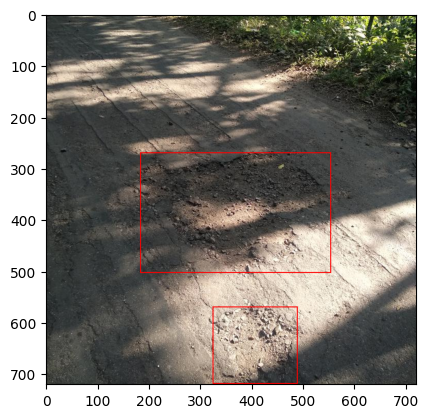

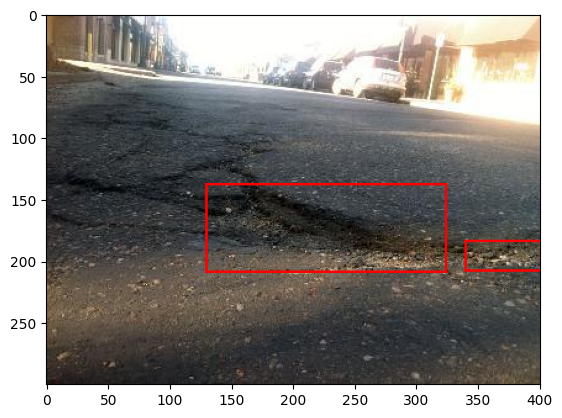

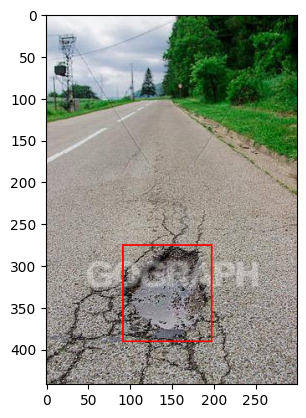

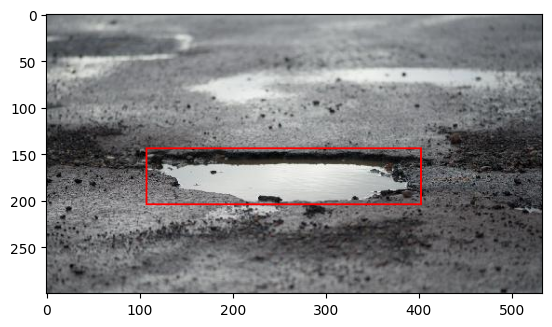

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


size = 128
# Define the transform with resizing and center cropping
train_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create PH2 dataset
dataset = PhC(transform=train_transform, data_path=data_path)

# Custom collate function
def my_collate(batch):
    images, boxes = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, boxes

# Create data loader with custom collate function
batch_size = 1
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=3, collate_fn=my_collate)

# Set the maximum number of images to display
max_images_to_display = 4

# Counter for displayed images
displayed_images = 0

# Iterate over the DataLoader
for images, boxes in train_loader:
    # Convert the images to numpy arrays
    images_np = images.permute(0, 2, 3, 1).numpy()

    # Iterate over each sample in the batch
    for i in range(batch_size):
        if displayed_images >= max_images_to_display:
            break

        image_np = images_np[i]
        boxes_sample = boxes[i]

        # Create a PIL image from the numpy array
        image_pil = Image.fromarray((image_np * 255).astype('uint8'))

        # Create a draw object to draw bounding boxes on the image
        draw = ImageDraw.Draw(image_pil)

        # Iterate over each bounding box in the sample
        for box in boxes_sample:
            # Draw the bounding box on the image
            draw.rectangle([box[0], box[1], box[2]+box[0], box[3]+box[1]], outline='red', width=2)

        # Show the image with bounding boxes
        plt.imshow(image_pil)
        plt.show()

        # Increment the counter
        displayed_images += 1

    # Break out of the outer loop if the desired number of images is displayed
    if displayed_images >= max_images_to_display:
        break


In [9]:
pip install opencv-contrib-python numpy

Note: you may need to restart the kernel to use updated packages.


In [11]:
import cv2
def selective_search(image, num_proposals, method="fast"):
    # image = cv2.imread(image_path)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    ss.setBaseImage(image)

    if method == "fast":
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    rects = ss.process()
    selected_rects = rects[:num_proposals]
    return selected_rects

In [13]:
# Load an image using OpenCV
image_path = '02516_pothole_w3/data/Potholes/annotated-images/img-631.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

(300, 452, 3)


In [14]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.

    Parameters:
    - box1, box2: Bounding boxes in the format (x, y, width, height)

    Returns:
    - IoU score
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection rectangle
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = min(x1 + w1, x2 + w2) - x_intersection
    h_intersection = min(y1 + h1, y2 + h2) - y_intersection

    # Check for no overlap
    if w_intersection <= 0 or h_intersection <= 0:
        return 0.0

    # Calculate area of intersection and union
    area_intersection = w_intersection * h_intersection
    area_union = w1 * h1 + w2 * h2 - area_intersection

    # Calculate IoU
    iou = area_intersection / area_union

    return iou

In [83]:
def label_proposals(all_proposals, labels, max_threshold_iou=0.7, min_threshold_iuo=0.3):
    best_bbs = []
    worst_bbs = []
    for label in labels[0]:
        max_iou = max_threshold_iou
        best_bb = None
        worst_bb = None
        for proposal in all_proposals:
            iou = calculate_iou(proposal, label)
            if iou >= max_iou:
                max_iou = iou
                best_bb = (proposal, "pothole")
            if iou < min_threshold_iuo:
                worst_bb = proposal
                if worst_bb is not None:
                    worst_bbs.append(worst_bb)
        if best_bb is not None:
            best_bbs.append(best_bb)
        
    # Ensure that len(worst_bbs) is 3 times the length of best_bbs
    target_length = len(best_bbs) * 3
    if len(worst_bbs) > target_length:
        worst_bbs = worst_bbs[:target_length]
    return best_bbs, worst_bbs

In [84]:
image, labels = next(iter(train_loader))
image = image.squeeze().permute(1, 2, 0).numpy()
all_proposals = selective_search(image, 100,method="notsofast")
best_bbs, worst_bbs = label_proposals(all_proposals, labels)


In [85]:
id = 0
images = []
labels_s = []
best_bbs_s = []
worst_bbs_s = []
for image, labels in train_loader:
    id += 1
    if id == 6:
        break
    image = image.squeeze().permute(1, 2, 0).numpy()
    all_proposals = selective_search(image, 5000,method="notsofast")
    best_bbs, worst_bbs = label_proposals(all_proposals, labels)
    best_bbs_s.append(best_bbs)
    worst_bbs_s.append(torch.tensor(worst_bbs))
    images.append(image)
    labels_s.append(labels)

/tmp/ipykernel_10407/1408667997.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  worst_bbs_s.append(torch.tensor(worst_bbs))


In [86]:
print(worst_bbs_s)
print(len(worst_bbs_s))
print(best_bbs_s)
print(len(best_bbs_s))

[tensor([]), tensor([[320, 320, 126,  64],
        [366, 686,  36,  34],
        [107, 688,  49,  20]], dtype=torch.int32), tensor([]), tensor([[336, 121,  32,  24],
        [ 49, 577,  30,  30],
        [208,  96,  16,  16],
        [ 17,  81,  30,  30],
        [  0,   0, 720, 720],
        [ 27, 553,  20,  23],
        [160, 297,  89,  70],
        [144,  96,  16,  32],
        [  0, 433,  96, 271]], dtype=torch.int32), tensor([[  9,  59,  16,  41],
        [185, 120,  85,  31],
        [124,  87,  20,  20]], dtype=torch.int32)]
5
[[], [(array([160, 304, 250, 112], dtype=int32), 'pothole')], [], [(array([335, 244,  98,  82], dtype=int32), 'pothole'), (array([273, 332, 177, 208], dtype=int32), 'pothole'), (array([ 59, 424, 168,  98], dtype=int32), 'pothole')], [(array([176, 167, 128,  51], dtype=int32), 'pothole')]]
5


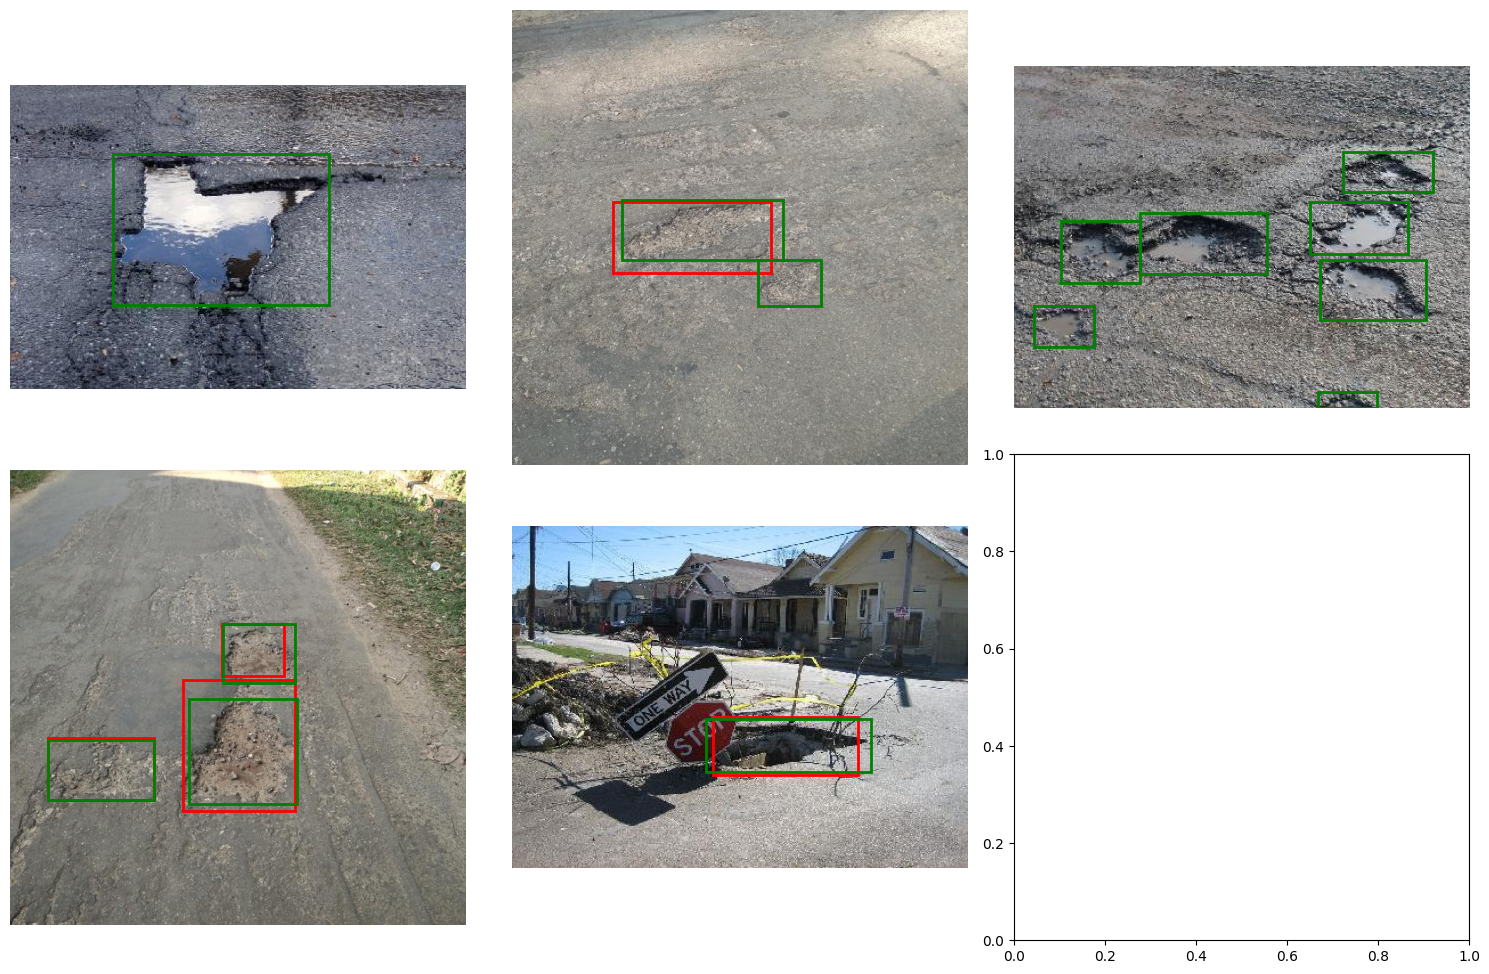

In [87]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, img in enumerate(images):
    axes[idx].imshow(img)
    axes[idx].axis('off')
    cur_bbs = best_bbs_s[idx]
    for bbs in cur_bbs:
        cords = bbs[0]
        if cords is not None:
            rect = patches.Rectangle((cords[0], cords[1]), cords[2], cords[3], linewidth=2, edgecolor='r', facecolor='none')
            axes[idx].add_patch(rect)

    labels = labels_s[idx][0]
    for label in labels:
        if label is not None:
            rect = patches.Rectangle((label[0], label[1]), label[2], label[3], linewidth=2, edgecolor='g', facecolor='none')
            axes[idx].add_patch(rect)   
# Add the rectangle to the Axes
# ax.add_patch(rect)

# Show the plot
plt.tight_layout()
plt.show()


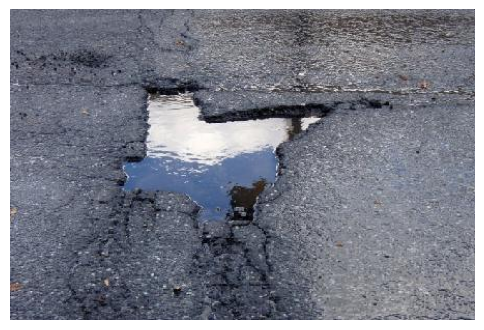

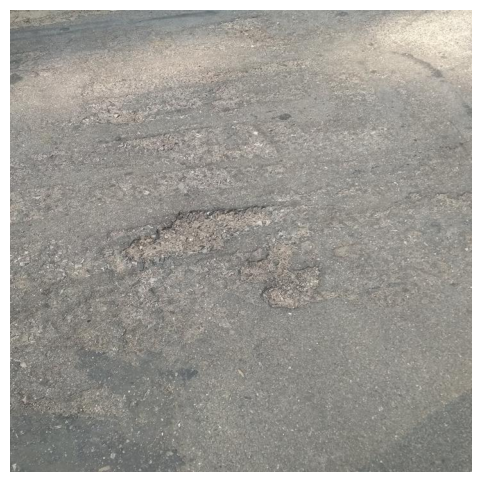

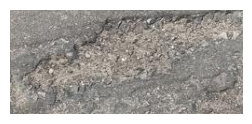

TypeError: iteration over a 0-d tensor

In [88]:
def clip_image(image, coordinates):
    x, y, w, h = map(int, coordinates)
    clipped_segment = image[y:y+h, x:x+w]
    return clipped_segment

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming best_bbs_s contains bounding box coordinates for each image
for idx, img in enumerate(images):
    # Assuming best_bbs_s contains bounding box coordinates for each image
    cur_bbs = best_bbs_s[idx]

    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    # Crop and display images based on bounding boxes
    for bbs in cur_bbs:
        cords = bbs[0]
        if cords is not None:
            # Crop the image based on bounding box coordinates
            cropped_img = clip_image(img, cords)

            # Display the cropped image
            plt.figure(figsize=(3, 3))
            plt.imshow(cropped_img)
            plt.axis('off')

            plt.show()
            
    wcur_bbs = worst_bbs_s[idx]     
    for bbs in wcur_bbs:
        cords = bbs[0]
        # Crop the image based on bounding box coordinates
        cropped_img = clip_image(img, cords)

            # Display the cropped image
        plt.figure(figsize=(3, 3))
        plt.imshow(cropped_img)
        plt.axis('off')

        plt.show()

In [ ]:
# List to store cropped images and labels
cropped_data_list = []

# Assuming best_bbs_s contains bounding box coordinates for each image
for idx, img in enumerate(images):
    # Assuming best_bbs_s contains bounding box coordinates for each image
    cur_bbs = worst_bbs_s[idx]
    labels = labels_s[idx][0]  # Assuming labels_s contains label information for each image
    
    # Crop and append images based on bounding boxes
    if cur_bbs.size()[0] != 0:
        for bbs in cur_bbs:
            print(bbs)
            cords = bbs
            if cords is not None:
                # Crop the image based on bounding box coordinates
                cropped_img = clip_image(img, cords)

                # Append the cropped image and labels to the list
                cropped_data_list.append({"image": cropped_img, "labels": labels})

# Display the cropped images and labels outside the loop
for data in cropped_data_list:
    plt.figure(figsize=(3, 3))
    plt.imshow(data["image"])
    plt.axis('off')
    
    # Optionally, display labels on the image
    for label in data["labels"]:
        rect = patches.Rectangle((label[0], label[1]), abs(label[2] - label[0]), abs(label[3] - label[1]),
                                 linewidth=2, edgecolor='g', facecolor='none')
        plt.gca().add_patch(rect)
    
    plt.show()

In [93]:
print(worst_bbs_s)
print(labels_s)

[tensor([]), tensor([[320, 320, 126,  64],
        [366, 686,  36,  34],
        [107, 688,  49,  20]], dtype=torch.int32), tensor([]), tensor([[336, 121,  32,  24],
        [ 49, 577,  30,  30],
        [208,  96,  16,  16],
        [ 17,  81,  30,  30],
        [  0,   0, 720, 720],
        [ 27, 553,  20,  23],
        [160, 297,  89,  70],
        [144,  96,  16,  32],
        [  0, 433,  96, 271]], dtype=torch.int32), tensor([[  9,  59,  16,  41],
        [185, 120,  85,  31],
        [124,  87,  20,  20]], dtype=torch.int32)]
[(tensor([[101,  67, 213, 149]]),), (tensor([[173, 301, 256,  95],
        [389, 396, 100,  72]]),), (tensor([[110, 128, 112,  54],
        [ 41, 135,  69,  55],
        [ 17, 210,  53,  36],
        [289,  75,  79,  35],
        [260, 119,  86,  45],
        [269, 170,  93,  52],
        [267, 286,  52,  14]]),), (tensor([[337, 244, 114,  93],
        [282, 362, 172, 166],
        [ 60, 428, 168,  94]]),), (tensor([[170, 169, 145,  46]]),)]


In [69]:
# Instantiate the VGG11 model with or without pretrained weights
model = models.vgg16(pretrained=True)

# Modify the classifier for your specific task
# Example: Replace the final fully connected layer for binary classification
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),  # Add a dropout layer with dropout probability of 0.5
    nn.Linear(1024, 2)  # Change 2 to the number of classes in your dataset
)

# Insert batch normalization after each convolutional layer
for layer in model.classifier.children():
    if isinstance(layer, nn.Conv2d):
        model.features[model.features.index(layer)] = nn.Sequential(
            layer,
            nn.BatchNorm2d(layer.out_channels),
            nn.ReLU(inplace=True)
        )

# Set device and define loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
num_epochs = 10

for epoch in tqdm(range(num_epochs), unit='epoch'):
    # For each epoch
    model.train()
    train_correct = 0

    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)

        # Zero the gradients computed for each weight
        optimizer.zero_grad()
        
        # Forward pass your image through the network
        output = model(data)
        
        # Compute the loss
        loss = criterion(output, target)
        
        # Backward pass through the network
        loss.backward()
        
        # Update the weights
        optimizer.step()

        # Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target == predicted).sum().cpu().item()
        
    scheduler.step()  # Update the learning rate at the end of each epoch
    # Compute the test accuracy
    
    model.eval()
    test_correct = 0
    correct_indices = []  # List to store indices of correct predictions
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []
    correct_images = []  # List to store correctly predicted images
    correct_labels = []
    correct_predictions = []

    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            output = model(data)

        predicted = output.argmax(1)
        target = target.to(device)

        correct_mask = target == predicted
        correct_indices.extend([i for i, value in enumerate(correct_mask) if value])

        misclassified_mask = target != predicted
        misclassified_images.extend(data[misclassified_mask])
        misclassified_labels.extend(target[misclassified_mask])
        misclassified_predictions.extend(predicted[misclassified_mask])

        correct_images.extend(data[correct_mask])
        correct_labels.extend(target[correct_mask])
        correct_predictions.extend(predicted[correct_mask])

        test_correct += correct_mask.sum().item()